In [13]:
import os.path

import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from omegaconf import OmegaConf
from train._main import train_model
from data._main import get_dataset
from data._utils import load_Flavell2023, load_Uzel2022
from train._utils import model_predict, make_predictions
from visualization._utils import plot_targets_predictions, plot_correlation_scatterplot
from models._utils import NetworkLSTM, LinearNN, NeuralCFC
from utils import DEVICE
from analysis._utils import *
import itertools
import yaml

In [6]:
config = OmegaConf.load("../conf/analysis.yaml")

In [25]:
configs = {}
for file_path in find_config_files("../logs/single_dataset"):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        parent_dir = os.path.dirname(file_path)
        if os.exists(os.path.join(parent_dir, "loss_curves.csv")):
            loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
            loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
            configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))



In [23]:
configs["../logs/single_dataset/2023_04_11_10_39_22/9"]

(0.0096286535,
 {'preprocess': {'url': 'https://www.dropbox.com/s/lw9cblxawqsbr2w/opensource_data.zip?dl=1', 'zipfile': 'opensource_data.zip', 'dataset': 'all', 'raw_dir': 'data/raw', 'smooth': 'fft'}, 'dataset': {'name': 'Kato2015'}, 'model': {'type': 'NetworkLSTM', 'input_size': 302, 'hidden_size': 128, 'num_layers': 1, 'loss': 'l1'}, 'visualize': {'log_dir': 'logs/hydra/2023_04_11_10_39_22/9', 'worm': 'worm1', 'neuron': 'AVAL'}, 'train': {'learn_rate': 0.01, 'seq_len': 100, 'k_splits': 2, 'epochs': 5000, 'save_freq': 100, 'smooth_data': True, 'reverse': False, 'num_batches': 4, 'train_size': 1500, 'test_size': 500, 'shuffle': True, 'tau_in': 1, 'tau_out': 1, 'optimizer': 'SGD'}, 'globals': {'use_residual': False, 'shuffle': False}, 'timestamp': '2023_04_11_10_40_38', 'num_unique_worms': 12})

In [32]:
trailing_dict = {}
for key, value in configs.items():
    dataset_name = value[1]["dataset"]["name"]
    train_size = value[1]["train"]["train_size"]
    loss = value[0]
    print(f"{dataset_name} {train_size} {loss}")
    if dataset_name in trailing_dict.keys():
        trailing_dict[dataset_name].update({train_size: loss})
    else:
        trailing_dict[dataset_name] = {train_size: loss}

Kato2015 1500 0.0096286535
Kato2015 10 0.08691644
Kato2015 2300 0.009191797
Kato2015 1000 0.00955018
Kato2015 700 0.009673999
Kato2015 30 0.042408153
Kato2015 2000 0.008906067
Kato2015 1200 0.010922853
Kato2015 300 0.009890792
Kato2015 100 0.012980773
Kato2015 2600 0.0108323535
Kato2015 50 0.020804217
Kato2015 3000 0.008924816
Kato2015 500 0.0098095555
Flavell2023 1500 0.036691252
Flavell2023 10 0.123305425
Flavell2023 2300 0.036813922
Flavell2023 2000 0.040483024
Flavell2023 2600 0.039884523
Flavell2023 3000 0.039527185
Skora2018 1500 0.008212786
Skora2018 10 0.08284214
Skora2018 2300 0.007644741
Skora2018 1000 0.007751465
Skora2018 700 0.0079692975
Skora2018 30 0.034693126
Skora2018 2000 0.0077224337
Skora2018 1200 0.00973957
Skora2018 300 0.008649044
Skora2018 100 0.010860867
Skora2018 2600 0.009349192
Skora2018 50 0.016950607
Skora2018 3000 0.007984058
Skora2018 500 0.008043323
Kaplan2020 1500 0.005138515
Kaplan2020 10 0.071548186
Kaplan2020 2300 0.005335227
Kaplan2020 1000 0.00610

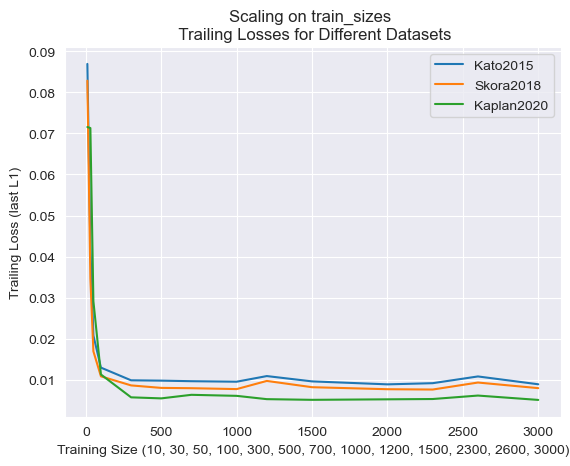

In [43]:
x = []
for dataset_name, dataset_dict in trailing_dict.items():
    if dataset_name == "Flavell2023":
        continue
    sorted_x, sorted_y = zip(*sorted(zip(list(dataset_dict.keys()), list(dataset_dict.values()))))
    x = sorted_x
    plt.plot(sorted_x, sorted_y, label=dataset_name)

plt.legend()
plt.xlabel("Training Size " + str(x))
plt.ylabel("Trailing Loss (last L1)")
plt.title("Scaling on train_sizes \n Trailing Losses for Different Datasets")
plt.savefig("../analysis/figures/trailing_loss.png")

In [47]:
def plot_trailing_loss_vs_parameter_legend(config_pardir, parameter, legend):
    configs = {}
    # go through all the config files and get the parameters and the loss
    for file_path in find_config_files(config_pardir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
                loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))

    parameters = parameter.split(".")
    param_name = parameters[1]
    legends = legend.split(".")

    # get the trailing loss for each parameter value
    trailing_dict = {}
    for key, value in configs.items():
        legend_name = value[1][legends[0]][legends[1]]
        param_value = value[1][parameters[0]][parameters[1]]
        loss = value[0]
        print(f"{legend_name} {param_value} {loss}")
        if legend_name in trailing_dict.keys():
            trailing_dict[legend_name].update({param_value: loss})
        else:
            trailing_dict[legend_name] = {param_value: loss}

    # plot the trailing loss for each parameter value
    x = []
    for para_n, val_dict in trailing_dict.items():
        sorted_x, sorted_y = zip(*sorted(zip(list(val_dict.keys()), list(val_dict.values()))))
        x = sorted_x
        plt.plot(sorted_x, sorted_y, label=para_n)

    plt.legend()
    plt.xlabel("Training Size " + str(x))
    plt.ylabel("Trailing Loss (last L1)")
    plt.title("Scaling on train_sizes \n Trailing Losses for Different " + str(legends[1]) + "s")
    plt.savefig("../analysis/figures/trailing_loss_on_"+ str(param_name) + ".png")


Kato2015 1500 0.0096286535
Kato2015 10 0.08691644
Kato2015 2300 0.009191797
Kato2015 1000 0.00955018
Kato2015 700 0.009673999
Kato2015 30 0.042408153
Kato2015 2000 0.008906067
Kato2015 1200 0.010922853
Kato2015 300 0.009890792
Kato2015 100 0.012980773
Kato2015 2600 0.0108323535
Kato2015 50 0.020804217
Kato2015 3000 0.008924816
Kato2015 500 0.0098095555
Flavell2023 1500 0.036691252
Flavell2023 10 0.123305425
Flavell2023 2300 0.036813922
Flavell2023 2000 0.040483024
Flavell2023 2600 0.039884523
Flavell2023 3000 0.039527185
Skora2018 1500 0.008212786
Skora2018 10 0.08284214
Skora2018 2300 0.007644741
Skora2018 1000 0.007751465
Skora2018 700 0.0079692975
Skora2018 30 0.034693126
Skora2018 2000 0.0077224337
Skora2018 1200 0.00973957
Skora2018 300 0.008649044
Skora2018 100 0.010860867
Skora2018 2600 0.009349192
Skora2018 50 0.016950607
Skora2018 3000 0.007984058
Skora2018 500 0.008043323
Kaplan2020 1500 0.005138515
Kaplan2020 10 0.071548186
Kaplan2020 2300 0.005335227
Kaplan2020 1000 0.00610

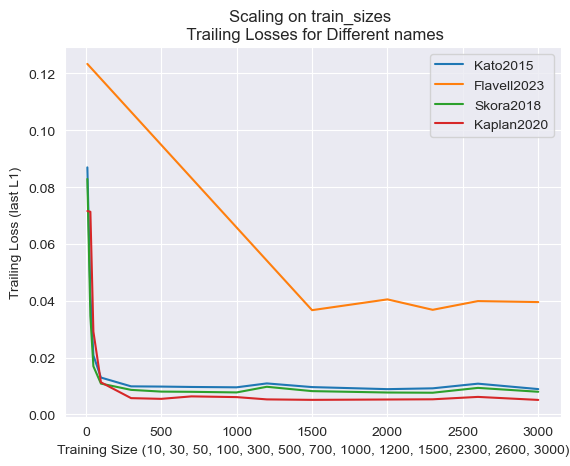

In [48]:
plot_trailing_loss_vs_parameter_legend("../logs/single_dataset", "train.train_size", "dataset.name")